# What is the True Normal Human Body Temperature? 

#### Background

The mean normal body temperature was held to be 37$^{\circ}$C or 98.6$^{\circ}$F for more than 120 years since it was first conceptualized and reported by Carl Wunderlich in a famous 1868 book. But, is this value statistically correct?

<h3>Exercises</h3>

<p>In this exercise, you will analyze a dataset of human body temperatures and employ the concepts of hypothesis testing, confidence intervals, and statistical significance.</p>

<p>Answer the following questions <b>in this notebook below and submit to your Github account</b>.</p> 

<ol>
<li>  Is the distribution of body temperatures normal? 
    <ul>
    <li> Although this is not a requirement for the Central Limit Theorem to hold (read the introduction on Wikipedia's page about the CLT carefully: https://en.wikipedia.org/wiki/Central_limit_theorem), it gives us some peace of mind that the population may also be normally distributed if we assume that this sample is representative of the population.
    <li> Think about the way you're going to check for the normality of the distribution. Graphical methods are usually used first, but there are also other ways: https://en.wikipedia.org/wiki/Normality_test
    </ul>
<li>  Is the sample size large? Are the observations independent?
    <ul>
    <li> Remember that this is a condition for the Central Limit Theorem, and hence the statistical tests we are using, to apply.
    </ul>
<li>  Is the true population mean really 98.6 degrees F?
    <ul>
    <li> First, try a bootstrap hypothesis test.
    <li> Now, let's try frequentist statistical testing. Would you use a one-sample or two-sample test? Why?
    <li> In this situation, is it appropriate to use the $t$ or $z$ statistic? 
    <li> Now try using the other test. How is the result be different? Why?
    </ul>
<li>  Draw a small sample of size 10 from the data and repeat both frequentist tests. 
    <ul>
    <li> Which one is the correct one to use? 
    <li> What do you notice? What does this tell you about the difference in application of the $t$ and $z$ statistic?
    </ul>
<li>  At what temperature should we consider someone's temperature to be "abnormal"?
    <ul>
    <li> As in the previous example, try calculating everything using the boostrap approach, as well as the frequentist approach.
    <li> Start by computing the margin of error and confidence interval. When calculating the confidence interval, keep in mind that you should use the appropriate formula for one draw, and not N draws.
    </ul>
<li>  Is there a significant difference between males and females in normal temperature?
    <ul>
    <li> What testing approach did you use and why?
    <li> Write a story with your conclusion in the context of the original problem.
    </ul>
</ol>

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

#### Resources

+ Information and data sources: http://www.amstat.org/publications/jse/datasets/normtemp.txt, http://www.amstat.org/publications/jse/jse_data_archive.htm
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet

****

#### Data Setup

In [1]:
import pandas as pd

df = pd.read_csv('data/human_body_temperature.csv')

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import ztest
%matplotlib inline

Use Seaborn style for graphic representation

In [3]:
sns.set()

Review columns info and understanding the shape of the sample set. It has 130 rows and 3 columns

In [4]:
print(df.info())
print(df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130 entries, 0 to 129
Data columns (total 3 columns):
temperature    130 non-null float64
gender         130 non-null object
heart_rate     130 non-null float64
dtypes: float64(2), object(1)
memory usage: 3.1+ KB
None
(130, 3)


#### Question 1

Use graphical method by plotting the temperature data against a random sample normal distributed dataset in CDF form

In [5]:
# Rule of thumb is to set bins as the square root of the numbers of data points
bins = np.sqrt(len(df)).astype('int')
print(bins)

11


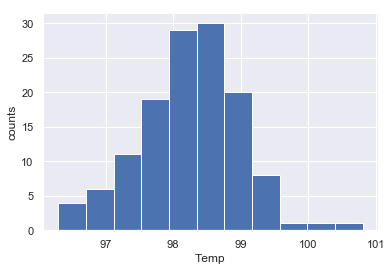

In [6]:
_ = plt.hist('temperature', data=df, bins=bins)
_ = plt.xlabel('Temp')
_ = plt.ylabel('counts')

Initial view suggests that data are normally distributed. We need to further confirm that by drawing a normal distributed samples from numpy

In [7]:
mu = np.mean(df.temperature)
sigma = np.std(df.temperature)
samples = np.random.normal(mu, sigma, 10000)

In [8]:
# Create a function to save typing time
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [9]:
x, y = ecdf(df.temperature)
x_theor, y_theor = ecdf(samples)

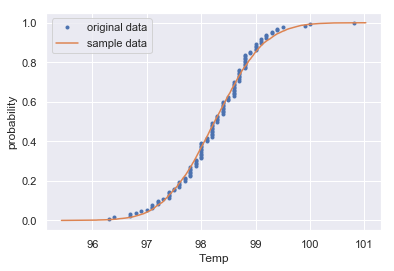

In [10]:
_ = plt.plot(x, y, marker='.', linestyle='none', label='original data')
_ = plt.plot(x_theor, y_theor, label='sample data')
_ = plt.xlabel('Temp')
_ = plt.ylabel('probability')
_ = plt.legend(loc='best')
plt.show()

The CDF curve for the dataset matches pretty well with the normal distributed sample set CDF.
We can conclude that the data collected are normally distributed.

#### Question 2

Per [t-distribution table](http://www.sthda.com/english/wiki/t-distribution-table) , a sample size need to be at least 25-30 to achieve normal distribution. Sample size >120 will have very similar distribution shape as infinite sample size. The dataset in this exercise has 130 samples. We can assume that the dataset has large enough sample and are normally distributed.

If the data were collected from babies or small children, the dependent variable will be ages. If the data were collected from a gym, the dependent variable will be the level of exercising. Since there is no specific information with regarding the conditions on how the data were collected, we assume that observations are independent. 

#### Question 3 - Is the true population mean really 98.6 degrees F?

Null Hypothesis - Sample mean is equal to mean population temperature of 98.6F

First shifted the sample mean to be equal to that of the population temperature mean

#### Bootstrap Hypothesis Test

In [11]:
sample_mean = np.mean(df.temperature)
print('Original sample_mean is {:.2f}'.format(sample_mean))
sample_shifted = df.temperature - sample_mean + 98.6

Original sample_mean is 98.25


In [12]:
# Create a function on drawing bootstrap samples
def bootstrap_replicate_1d(data, func):
    return func(np.random.choice(data, size=len(data)))

In [13]:
# Create another function to generate many bootstrap replicates 
def draw_bs_reps(data, func, size):
    bs_replicates = np.empty(size)
    for i in range(size):
        bs_replicates[i] = bootstrap_replicate_1d(data, func)
    return bs_replicates

In [14]:
# Get the set of means for the 10000 bootstrap replicates
bs_replicates = draw_bs_reps(sample_shifted, np.mean, 10000)

Identify the 95% confidence interval among the bs_replicates and p-value

In [15]:
conf_lv_95 = np.percentile(bs_replicates, [2.5, 97.5])
print('95% confidence interval {}'.format(conf_lv_95))

95% confidence interval [98.47461538 98.72692308]


In [16]:
# Calculating p-values
p = np.sum(bs_replicates <= sample_mean)/len(bs_replicates)
print('p-value: {}'.format(p))

p-value: 0.0


p-value equal to 0. We will reject the null hypothesis that the sample mean is equal to the population mean of 98.6F. This implies two possibilities:
1. Population temperature mean is no longer 98.6F
2. Sample data are not representative to true population

#### Frequentist statistical testing

The problem is trying access if the population mean is equal to a constant (i.e. 98.6F). Hence, it is a one sample test.

We have big enough sample size, hence we will use **z test**.

In [17]:
z = (sample_mean -98.6)/ (np.std(df.temperature) / np.sqrt(len(df)))

pval = 2 * (stats.norm.cdf(z))
print('z-score: {:.2f}'.format(z))
print('p-value: {:.2f}'.format(pval))

z-score: -5.48
p-value: 0.00


The z score is < 3 and p-value is zero. It suggest significant evidence to reject the null hypothesis.

**t-test**

In [18]:
t_statistics = stats.ttest_1samp(df.temperature, 98.6)
print('t-score: {:.2f}'.format(t_statistics.statistic))
print('p-value: {:.2f}'.format(t_statistics.pvalue))

t-score: -5.45
p-value: 0.00


t score <5 and p-value is zero, we will reject the null hypothesis

The z and t scores are slightly difference because z test uses population standard deviation/mean while t test uses the standard deviation/mean of the sample itself. are the same. When we have >30 samples, however the results between z and t tests are very close.

#### Question 4 - Draw a small sample of size 10 from the data and repeat both frequentist tests

Null Hypothesis - Sample mean is equal to mean population temperature of 98.6F

Drawing ten sample from the dataset and repeat all the steps that were run in question 3

In [19]:
ten_sample = df['temperature'].sample(n=10, random_state=3)
ten_sample_mean = np.mean(ten_sample)

#### z-test

In [20]:
z1 = (ten_sample_mean -98.6)/ (np.std(ten_sample) / np.sqrt(10))
# we want area on the left tail
pval1 = 2 * (stats.norm.cdf(z1))
print('z-score: {:.2f}'.format(z1))
print('p-value: {:.2f}'.format(pval1))

z-score: -2.33
p-value: 0.02


#### t-test

In [21]:
t_ten_sample = stats.ttest_1samp(ten_sample, 98.6)
print('t-score: {:.2f}'.format(t_ten_sample.statistic))
print('p-value: {:.2f}'.format(t_ten_sample.pvalue))

t-score: -2.21
p-value: 0.05


We will reject the null hypothesis under z-test, but fail to reject under t-test under 95% confidence level. t-test would provide a more conservative result for smaller sample.

#### Question 5 - At what temperature should we consider someone's temperature to be "abnormal"?

Under 95% confident level, we would regard abnormal temperature be 2 standard deviations from the mean of the population

For bootstrap method, we can reuse the the 95% confident interval calculated before

In [22]:
bs_replicates_orig = draw_bs_reps(df.temperature, np.mean, 10000)
conf_lv_95 = np.percentile(bs_replicates_orig, [2.5, 97.5])
print('Bootstrap confident interval: {}'.format(conf_lv_95))

Bootstrap confident interval: [98.12538462 98.37384615]


#### z test

In [23]:
# calculiate margin of error of using origin sample, using the formula of z * std/sqrt(n)
margin_error = 1.96 * np.std(df.temperature)/ np.sqrt(len(df.temperature))
confid_lv_z = [sample_mean - margin_error, sample_mean + margin_error]
print ('Margin of error: {}'.format(margin_error))
print ('z-test Confidence interval: {}'.format(confid_lv_z))

Margin of error: 0.125550964802579
z-test Confidence interval: [98.12367980442819, 98.37478173403336]


z test method indicates similar temperature range with 95% confidence, which is below 98.13F or above 98.38F.

In [24]:
# optional step: validate by using stats.norm.inteval function
stats.norm.interval(.95, loc=mu, scale=sigma/np.sqrt(len(df)))

(98.12368211145665, 98.37477942700491)

#### t test

In [25]:
# validate by using stats.t.inteval function
conv_inv_t = stats.t.interval(.95, len(df)-1, loc=mu, scale=sigma/np.sqrt(len(df)))
print('t-test Confidence interval: {}'.format(conv_inv_t))

t-test Confidence interval: (98.12249318821641, 98.37596835024515)


#### Question 6 - Is there a significant difference between males and females in normal temperature?

Null Hypothesis - males and females have the same mean body temperature.

It is a two sample test problem.

#### Bootstrap method

In [26]:
# Obtain samples for males and females
males = df[df.gender == 'M'].temperature
females = df[df.gender == 'F'].temperature
# Observed difference from the existing sample
mean_diff = np.mean(males) - np.mean(females)
print('Mean difference between males and females: {}'.format(mean_diff))

Mean difference between males and females: -0.289230769230727


In [27]:
# Shift sample
males_shifted = males - np.mean(males) + mu
females_shifted = females - np.mean(females) + mu

In [28]:
# Draw replicates
bs_rep_males = draw_bs_reps(males_shifted, np.mean, 10000)
bs_rep_females = draw_bs_reps(females_shifted, np.mean, 10000)

In [29]:
# Calculate difference in mean among the replicates
bs_rep_diff = np.abs(bs_rep_males - bs_rep_females)

# Calculiate p value on showing the observed difference is a result of chance
p = np.sum(bs_rep_diff >= np.abs(mean_diff)) / len(bs_rep_diff)
print ('p-value: {:.2f}'.format(p))

p-value: 0.02


It has 2% chance of getting the observed difference. We have significant evidence to reject the null hypothesis under 95% confidence level

Apply **z-test**. Using 95% confidence level

In [30]:
z_diff_in_mean = mean_diff/(np.sqrt(np.std(males)**2/len(males)+ np.std(females)**2/len(females)))
p_val_diff_in_mean = 2 * (1-stats.norm.cdf(np.abs(z_diff_in_mean)))
print ('z-score: {:.2f}'.format(z_diff_in_mean))
print ('p-value:{:.2f}'.format(p_val_diff_in_mean))

z-score: -2.30
p-value:0.02


In [31]:
# for validation purposes, calculating z-test using statsmodels
z_test = ztest(males, females)
print ('z-score: {:.2f}'.format(z_test[0]))
print ('p-value: {:.2f}'.format(z_test[1]))

z-score: -2.29
p-value: 0.02


p value is 2%, we will reject the null hypothesis under 95% confidence level

Apply **t test**

In [32]:
t_test1 = stats.ttest_ind(males, females)
print ('t-score: {:.2f}'.format(t_test1.statistic))
print ('p-value: {:.2f}'.format(t_test1.pvalue))

t-score: -2.29
p-value: 0.02


p-value is at 2%, we have significant evidence to reject the null hypothesis under 95% confidence level

#### Conclusion

The mean normal body temperature of 98.6F is not necessarily true in today's population. The sample temperature mean is 98.2F, which is 0.4F below the historical mean.

Why the decrease? One area which would worth exploring is the current living environment. Perhaps more people have moved to warmer areas, in which their body temperatures don't need to stay that high to remain warm. With the advance in technology, a lot of labor-intensive works are replaced by machines. As a result, people no longer need to eat that much food to perform daily tasks - less energy needed in the body, hence body temperature decreases. 

In related to that, people today have more clothing and shelters for body protection from the wild environment, the biological part of the body may change over time that it needs body fat to maintain high body temperature.